# Predicting Advertisement clicks

The goal of this project is to predict whether a user clicked on an advert given their web activity. The data given shows how many times a user had viewed an advert on a particular website and if they clicked on it or not.

In [224]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFpr, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

df = pd.read_csv('ad_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     10000 non-null  object
 1   Addthis        10000 non-null  int64 
 2   Bebo           10000 non-null  int64 
 3   Blogcatalog    10000 non-null  int64 
 4   Blogger        10000 non-null  int64 
 5   Buddymedia     10000 non-null  int64 
 6   Cnet           10000 non-null  int64 
 7   Conduit        10000 non-null  int64 
 8   Customerlobby  10000 non-null  int64 
 9   Delicious      10000 non-null  int64 
 10  Digg           10000 non-null  int64 
 11  Diigo          10000 non-null  object
 12  Docs           10000 non-null  int64 
 13  Docstoc        10000 non-null  int64 
 14  Download       10000 non-null  int64 
 15  Dropbox        10000 non-null  int64 
 16  Drupal         10000 non-null  int64 
 17  Epinions       10000 non-null  int64 
 18  Evernote       10000 non-nu

In [225]:
df

,Unnamed: 0,Addthis,Bebo,Blogcatalog,Blogger,Buddymedia,Cnet,Conduit,Customerlobby,Delicious,...,Vimeo,Vocus,Wetpaint,Wordpress,Xanga,Yelp,Yfrog,Youtube,Yuku,Click
0,dmp923122274,0,0,2,0,0,3,6,0,0,...,0,0,0,4,0,0,1,0,1,0
1,dmp458034174,0,3,0,0,0,0,1,0,0,...,0,0,0,12,0,2,2,12,0,0
2,dmp364043571,0,2,0,0,0,0,0,0,2,...,0,0,0,11,0,0,0,0,0,0
3,dmp461339655,0,0,0,0,0,0,0,0,0,...,0,0,0,6,0,0,0,22,0,0
4,dmp549691332,0,0,0,0,0,5,7,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,dmp910305497,0,0,0,20,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
9996,dmp877506661,0,0,2,0,0,2,0,0,1,...,0,0,1,0,3,0,2,0,0,0
9997,dmp356452644,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,2,0,0
9998,dmp689019375,3,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


All columns have 10000 non-null variables and are all type int62 aside from Diigo. We can check for all no numeric data in this column and remove it.

In [226]:
x = df['Diigo']

# find all non numeric data
error_string = x.loc[x.map(lambda x : not x.isnumeric())].unique()

# convert to null and remove
df = df.replace(error_string, np.nan).dropna()

print(error_string)

['Error: value not found']


The strings turned out to be null values and were removed.

We can also remove duplicate users from the user id column. 

In [227]:
# remove duplicate users and user column
user_col = df.columns[0]
df = df.drop_duplicates(subset=user_col)
df = df.drop(columns=user_col)

# convert to same data type
df = df.apply(lambda x : np.array(x, dtype=np.int32))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9358 entries, 0 to 9999
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Addthis        9358 non-null   int32
 1   Bebo           9358 non-null   int32
 2   Blogcatalog    9358 non-null   int32
 3   Blogger        9358 non-null   int32
 4   Buddymedia     9358 non-null   int32
 5   Cnet           9358 non-null   int32
 6   Conduit        9358 non-null   int32
 7   Customerlobby  9358 non-null   int32
 8   Delicious      9358 non-null   int32
 9   Digg           9358 non-null   int32
 10  Diigo          9358 non-null   int32
 11  Docs           9358 non-null   int32
 12  Docstoc        9358 non-null   int32
 13  Download       9358 non-null   int32
 14  Dropbox        9358 non-null   int32
 15  Drupal         9358 non-null   int32
 16  Epinions       9358 non-null   int32
 17  Evernote       9358 non-null   int32
 18  Facebook       9358 non-null   int32
 19  Faves 

In [228]:
df.describe()

,Addthis,Bebo,Blogcatalog,Blogger,Buddymedia,Cnet,Conduit,Customerlobby,Delicious,Digg,...,Vimeo,Vocus,Wetpaint,Wordpress,Xanga,Yelp,Yfrog,Youtube,Yuku,Click
count,9358.00000,9358.000000,9358.000000,9358.000000,9358.0,9358.000000,9358.000000,9358.000000,9358.000000,9358.000000,...,9358.000000,9358.000000,9358.000000,9358.000000,9358.000000,9358.000000,9358.000000,9358.000000,9358.000000,9358.000000
mean,0.42274,0.779547,0.563261,2.851250,0.0,1.948814,2.140094,0.000214,0.391644,1.014319,...,0.412054,0.040286,0.295042,2.192883,0.463454,0.601838,0.379248,6.023616,0.207416,0.123210
std,1.01457,1.489811,1.195984,5.587825,0.0,2.939060,3.296851,0.014618,0.809241,2.274055,...,1.005973,0.196641,0.613028,3.708504,0.986767,1.195555,0.754102,7.884505,0.590112,0.328696
min,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,1.000000,0.000000,0.000000,0.0,4.000000,4.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000
max,6.00000,8.000000,7.000000,28.000000,0.0,15.000000,16.000000,1.000000,4.000000,13.000000,...,7.000000,1.000000,3.000000,19.000000,5.000000,7.000000,4.000000,36.000000,4.000000,1.000000


Looking at the describe table we see that some sites have not been visted by anyone as they have a min value of 0. Also the maxiumum value in the data frame is absurdly large and is liekly as mistake. The new maximum is 46 whihc ismore reasonable.

In [229]:
# check for constant column
var = df.var()
df = df.drop(columns=var.loc[var == 0].index)

print(df.max().max())
# drop extreme values
df = df.loc[~(df > 1000000).any(axis=1)]

print(df.shape)
print(df.max().max())

1883087125
(9357, 81)
46


## Feature distribution

The modal number of views for any given site is 0. The below distribution plots show that the data is more skewed to the left. I have chosen 4 popular sites that demonstrate the overall trend.

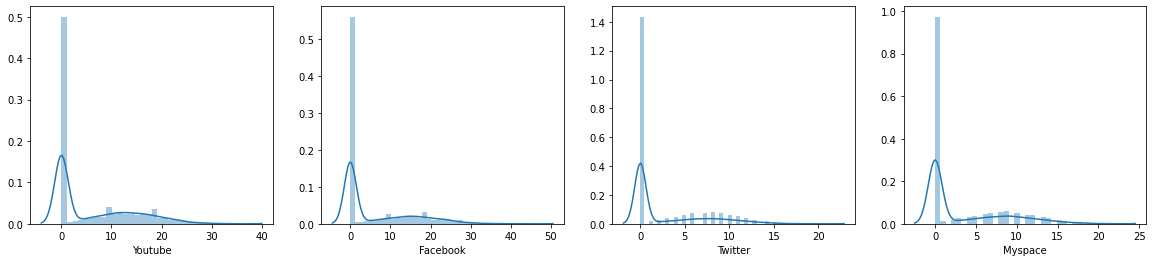

In [230]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))

sns.distplot(df['Youtube'], ax=axes[0])
sns.distplot(df['Facebook'], ax=axes[1])
sns.distplot(df['Twitter'], ax=axes[2])
sns.distplot(df['Myspace'], ax=axes[3])

We can apply an ansombe transformation which can make the data more normal. There is not a huge dfifference, but it does help slightly with performance.

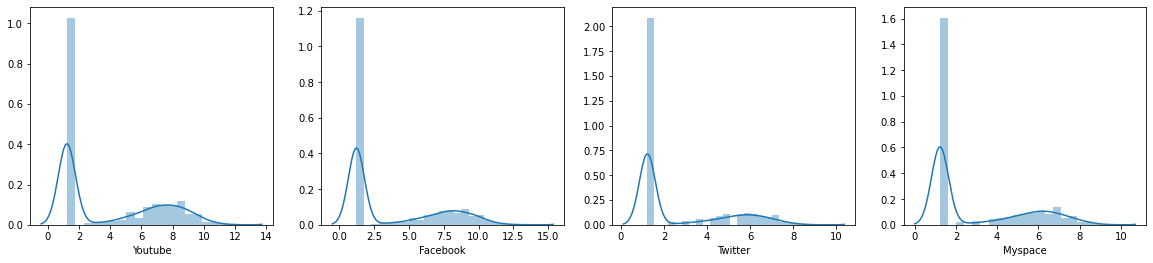

In [231]:
anscombe = lambda x : 2*np.sqrt(x + 3/8)

fig, axes = plt.subplots(1, 4, figsize=(20,4))

sns.distplot(anscombe(df['Youtube']), ax=axes[0])
sns.distplot(anscombe(df['Facebook']), ax=axes[1])
sns.distplot(anscombe(df['Twitter']), ax=axes[2])
sns.distplot(anscombe(df['Myspace']), ax=axes[3])

## Feature selction

All of the features are the same data type and represent the same thing just for different websites, so we can handle all of them together. Since we are using nuemrical data to predict categorical labels, and ANOVA-f test can be used to measure correlation. Webesites with a p value less that 0.05 have been remeoved.

In [232]:
# select features
features = []
for col in df.columns[:-1]:
    feature = np.array(df[col]).reshape(-1,1)
    label = df['Click']
    F, p = f_classif(feature, label)
    if p > 0.05:
        features.append(col)

df = df.drop(columns=features)

print(features)
df.shape

['Diigo', 'Docs', 'Dropbox', 'Jumptags', 'Netvibes', 'Twine', 'Ubertwitter', 'Yfrog']


(9357, 73)

The new number of columns is 73 so 8 websites have been removed.

## Dealing with unbalanced data

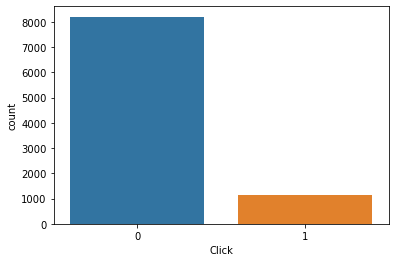

In [233]:
sns.countplot(df['Click'])
plt.show()

For the Click column a 1 represents a click and 0 represents no clicks. The countplot above shows that there are around 7 times more. 

In [234]:
# split into train test
df_train = df.sample(frac=0.8, random_state=0)
df_test = df.drop(df_train.index)

After splitting into test and train data we can over sample the smaller class so they are roughly even.

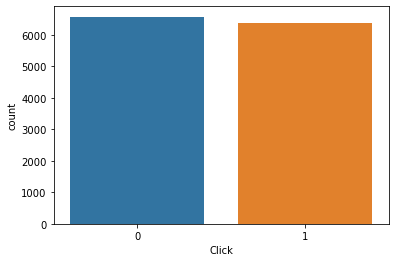

In [235]:
# over sample smaller class
click = df_train.loc[df['Click'] == 1]
no_click = df_train.loc[df['Click'] == 0]

click = click.sample(frac=7.0, replace=True, random_state=0)
df_train = pd.concat([click, no_click])

sns.countplot(df_train['Click'])
plt.show()

## The model

In [236]:
# split features and labels
x_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
x_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1] 

We can apply the ansombe transformation since the data a heavily skewed to the left.

In [237]:
# apply transforms to make distribution more normal
anscombe = lambda x : 2*np.sqrt(x + 3/8)
x_train = anscombe(x_train)
x_test = anscombe(x_test)

We can scale the features using the standard scaler which helps with performance.

In [238]:
# scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

I will try both logistic regression and a support vector classifier since all of the input data is numerical. 

In [239]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [240]:
cf = confusion_matrix(y_test, y_pred)

precision = cf[1,1]/(cf[1,1]+cf[0,1])
recall = cf[1,1]/(cf[1,1]+cf[1,0])
f1_score = 2*precision*recall/(precision + recall)

print(cf)
print(f'Precision: {precision} \nRecall: {recall} \nF1_score: {f1_score}')

[[1542   86]
 [  10  233]]
Precision: 0.7304075235109718 
Recall: 0.9588477366255144 
F1_score: 0.8291814946619217


In [241]:
model = SVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [242]:
cf = confusion_matrix(y_test, y_pred)

precision = cf[1,1]/(cf[1,1]+cf[0,1])
recall = cf[1,1]/(cf[1,1]+cf[1,0])
f1_score = 2*precision*recall/(precision + recall)

print(cf)
print(f'Precision: {precision} \nRecall: {recall} \nF1_score: {f1_score}')

[[1597   31]
 [  36  207]]
Precision: 0.8697478991596639 
Recall: 0.8518518518518519 
F1_score: 0.8607068607068608


Both models perform well. The logistic regression has a greater recall, whereas the SVC has a greater precision. I have experimented with changing the amount of over sampling of the smaller class and the logistic model seems more affected by this change. A higher amount of over sampling give a higher recall, while a lower amount gives a higher precision.